---

## Imports

In [1]:
import tobac 
print('For this cookbook, we are using tobac version:', tobac.__version__)

For this cookbook, we are using tobac version: 1.6.0


## Look at the distribution to verify that thresholds make sense

In [3]:
# read in the data 

In [2]:
from pathlib import Path 
import xarray as xr 

mpas_path = Path('/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_save/')
file_names = list(mpas_path.glob('diag.3.75km.2020-07-01*00.nc'))
iwp = xr.open_dataset(file_names[0])['ice_water_path'].compute().squeeze() / 1000 

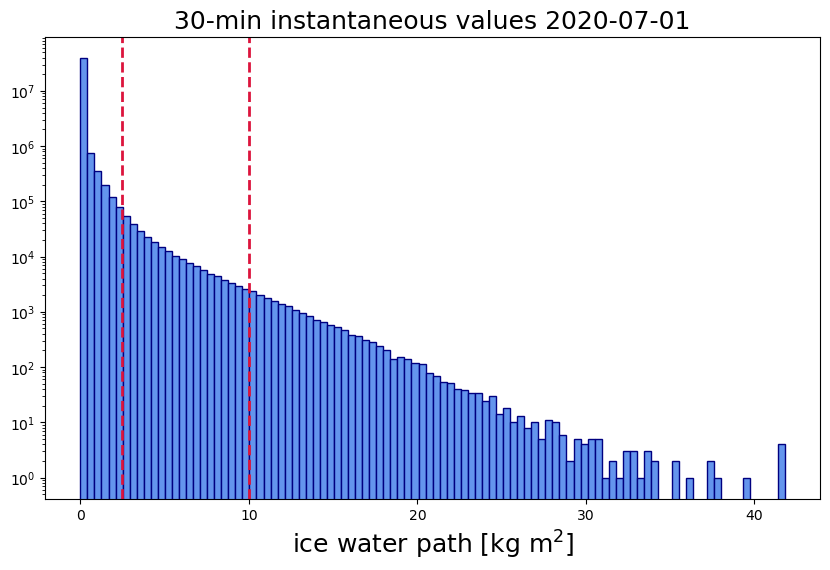

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

fs = 18
plt.title('30-min instantaneous values ' + str('2020-07-01'), fontsize = fs)
plt.hist(iwp, bins=100, log=True, color='cornflowerblue', edgecolor='navy')

thresholds = [2.5, 10]
for threshold in thresholds:
    plt.axvline(x=threshold, color='crimson', linestyle='--', linewidth=2, label='Threshold' + str(threshold))

plt.xlabel('ice water path [kg m$^2$]', fontsize = fs )
plt.show()

In [ ]:
# Read

In [4]:
# Get MPAS DYAMOND-3 data from NCAR catalog
import intake 
cat_url = "https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml"
cat = intake.open_catalog(cat_url)['NCAR']
dataset = 'mpas_dyamond3'
mpas = cat[dataset]
mpas_ds = mpas(zoom = 10, time='PT30M').to_dask()
mpas_ds

/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 7TB
Dimensions:             (time: 2161, cell: 12582912)
Coordinates:
  * cell                (cell) float64 101MB nan 1.0 2.0 ... 1.258e+07 1.258e+07
  * time                (time) datetime64[ns] 17kB 2020-01-20 ... 2020-03-05
Data variables: (12/63)
    cape                (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    cin                 (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    height_200hPa       (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    height_250hPa       (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    height_500hPa       (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    height_700hPa       (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    ...                  ...
    w_200hPa            (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    w_250hPa            (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    w_500hPa            (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    w_700hPa            (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    w_850hPa            (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>
    w_925hPa            (time, cell) float32 109GB dask.array<chunksize=(1, 3145728), meta=np.ndarray>

In [5]:
import xarray as xr 
import numpy as np 
import healpix


def latlon_remap_cells(grid_spacing, crs):
    lon = xr.DataArray(
        np.arange(grid_spacing/2, 360, grid_spacing),
        dims=("lon",), 
        name="lon", 
        attrs=dict(units="degrees", standard_name="longitude")
    )
    lat = xr.DataArray(
        np.arange(90 - grid_spacing/2, -90, -grid_spacing), 
        dims=("lat",), 
        name="lat", 
        attrs=dict(units="degrees", standard_name="latitude")
    )
    
    return xr.DataArray(
        healpix.ang2pix(crs.healpix_nside, *np.meshgrid(lon, lat), nest=crs.healpix_order, lonlat=True),
        coords=(lat, lon),
    )
    
zoom = 10
grid_spacing = 64 / 2**zoom
dxy = 1e5 * grid_spacing
print('grid spacing [in m]:', dxy)

### Regridding 

# add missing crs attribute for zoom level 10 
crs = xr.DataArray(
name="crs",
attrs={
    "grid_mapping_name": "healpix",
    "healpix_nside": 1024,
    "healpix_order": "nest",
},)

mpas_ds = mpas_ds.assign_coords(crs=crs)
pix = latlon_remap_cells(grid_spacing, mpas_ds.crs)

# Load data for a day
start = 0
end = 24
mpas_t = mpas_ds[["rainnc", "ice_water_path", "liquid_water_path"]].isel(time=slice(start, end)).load()
mpas_t['rainnc'] = mpas_t.rainnc.diff(dim='time')    

# Regrid to latlon
valid_mask = ~np.isnan(mpas_t['cell'].values)
mpas_clean = mpas_t.isel(cell=np.where(valid_mask)[0])
mpas_gridded = mpas_clean.drop_vars(["lat", "lon"], errors="ignore").sel(cell=pix, method="nearest")

grid spacing [in m]: 6250.0


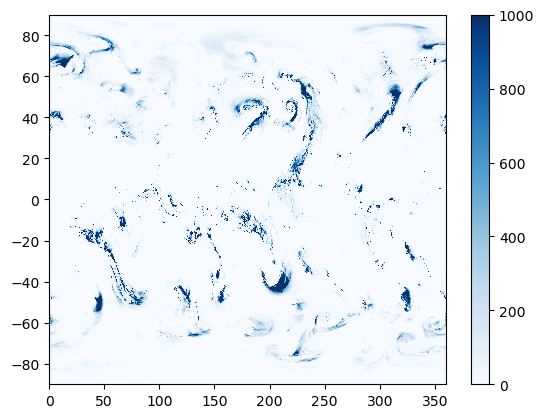

In [6]:
import matplotlib.pyplot as plt 
plt.pcolormesh(mpas_gridded.lon, mpas_gridded.lat, mpas_gridded.ice_water_path[-1], cmap = 'Blues', vmax = 1000)
plt.colorbar()
plt.show()

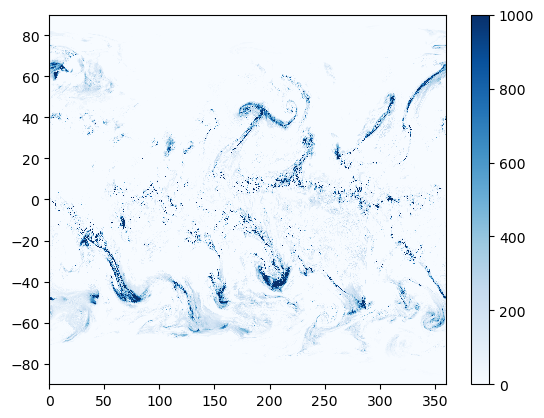

In [7]:
plt.pcolormesh(mpas_gridded.lon, mpas_gridded.lat, mpas_gridded.liquid_water_path[-1], cmap = 'Blues', vmax = 1000)
plt.colorbar()
plt.show()

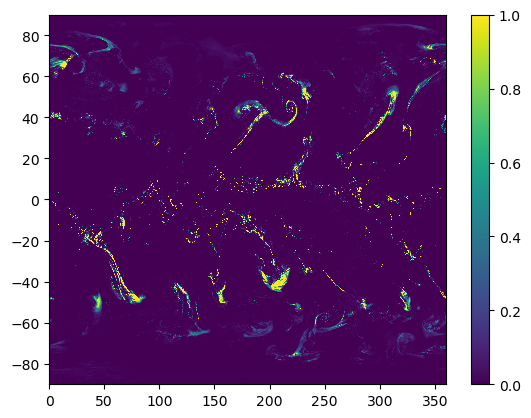

In [8]:
plt.pcolormesh(mpas_gridded.lon, mpas_gridded.lat, mpas_gridded.rainnc[-1], cmap = 'viridis', vmax = 1)
plt.colorbar()
plt.show()

## Feature detection

In [9]:
# set horizontal grid spacing [m] and temporal resolution [s]
dxy,dt= 14000, 3600 

# parameters for feature detection                                                           
parameters_features = {}
parameters_features['threshold']=[2.5, 10 ]  # thresholds for ice water path 
parameters_features['target']='maximum'
parameters_features['n_min_threshold']= 100  # minimum number of grid cells that need to be above specified threshold 

In [10]:
%%time 
input_data = mpas_gridded.ice_water_path / 1000 
storm_features = tobac.feature_detection_multithreshold(input_data, dxy, **parameters_features)

CPU times: user 8.8 s, sys: 572 ms, total: 9.37 s
Wall time: 10.7 s


## Segmentation and computation of feature statistics

In this step, we can calculate some bulk metrics for the storm objects detected in each timestep. 

In [11]:
# parameters for segmentation 
parameters_segmentation = {}
parameters_segmentation['threshold']= 0.25 # kg/m2 used to define the extent of the cloud objects                     
parameters_segmentation['target'] = "maximum"
parameters_segmentation['statistic'] = {"max_iwp": np.nanmax, 'total_iwp': np.nansum, 'mean_iwp': np.nanmean}

In [12]:
%%time 
mask, storm_features = tobac.segmentation_2D(storm_features, input_data, dxy, **parameters_segmentation)

CPU times: user 2min 24s, sys: 4.37 s, total: 2min 28s
Wall time: 2min 29s


In [13]:
# calculate statistics 
storm_features= tobac.utils.bulk_statistics.get_statistics_from_mask(
    storm_features, mask, mpas_gridded.liquid_water_path / 1000, statistic={"max_lwp": np.nanmax, "mean_lwp": np.nanmean, "total_lwp": np.nansum}, default=np.nan) 

storm_features = tobac.utils.bulk_statistics.get_statistics_from_mask(
    storm_features, mask, mpas_gridded.rainnc , statistic={"max_precip": np.nanmax, "mean_precip": np.nanmean, "total_precip": np.nansum}, default=np.nan) 

/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/tobac/utils/bulk_statistics.py:340: UserWarning: Not all timesteps have matching features
  warnings.warn("Not all timesteps have matching features", UserWarning)
/glade/work/kukulies/conda-envs/easypeasy/lib/python3.12/site-packages/tobac/utils/bulk_statistics.py:340: UserWarning: Not all timesteps have matching features
  warnings.warn("Not all timesteps have matching features", UserWarning)


In [14]:
# save features
storm_features.to_xarray().to_netcdf('iwp_lwp_precip_features_week.nc')

## Tracking

In [ ]:
# parameters for linking 
parameters_linking={}
parameters_linking['v_max']=1e2
parameters_linking['stubs']=3
parameters_linking['method_linking']= 'predict'
parameters_linking['PBC_flag'] ="hdim_2"
parameters_linking['min_h2'] = 0 
parameters_linking['max_h2'] = surface_olr_diff_gridded.lon.size

In [ ]:
Tracks = tobac.linking_trackpy(Features, None, dt=dt, dxy=dxy)

---